In [152]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import math
import matplotlib.pyplot as plt
import numpy as np

from collections import namedtuple

import tqdm

Изучим работу этого метода на нескольких функциях

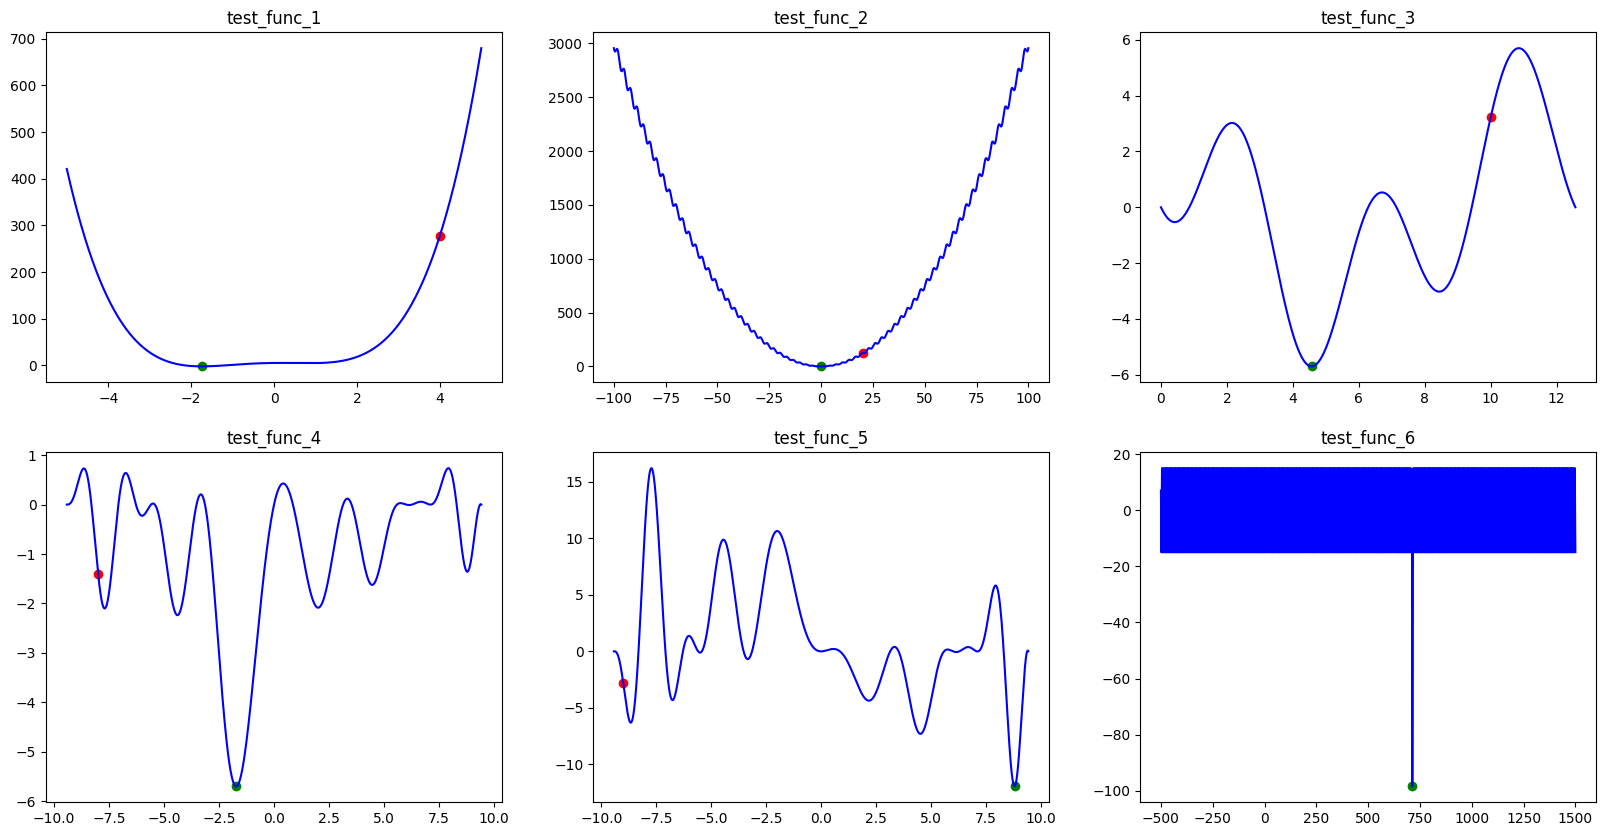

In [154]:
def clip(x, y, a, b):
    if np.isscalar(x):
        return y if a <= x <= b else 0
    y_copy = np.copy(y)
    y_copy[np.logical_or(x < a, b < x)] = 0
    return y_copy


def test_func_1(x):
    return x ** 4 + (x - 1.4) ** 3 + (x - 3) ** 2 + x - 1


def test_func_2(x):
    return x * np.sin(x) * np.cos(x) + 0.3 * x ** 2


def test_func_3(x):
    return clip(x, 6 * np.sin(x) * np.cos((x - 4) / 2), 0, 4 * math.pi)


def test_func_4(x):
    return clip(x, 6 * np.sin(x) * np.cos((x - 4) / 2) * np.sin((x - 6) / 5) * np.cos((x ** 2 - 3) / 6), -3 * math.pi,
                3 * math.pi)


def test_func_5(x):
    return clip(x, 6 * np.sin(x) * np.cos((x - 4) / 2) * np.sin((x - 6) / 5) * np.cos((x ** 2 - 3) / 6) * x,
                -3 * math.pi, 3 * math.pi)


def test_func_6(x):
    return -100 * np.exp(-(x - 713) ** 2) + 15 * np.sin(x)

TestFunc = namedtuple('TestFunc', ['func', 'expected', 'x0', 'a', 'b', 'k'])

test_cases = [
    TestFunc(test_func_1, -1.74, 4, -5, 5, 100),
    TestFunc(test_func_2, 0, 20, -100, 100, 100),
    TestFunc(test_func_3, 4.568, 10, 0, 4 * math.pi, 1000),
    TestFunc(test_func_4, -1.722, -8, -3 * math.pi, 3 * math.pi, 1000),
    TestFunc(test_func_5, 8.798, -9, -3 * math.pi, 3 * math.pi, 50000),
    TestFunc(test_func_6, 713.075, 0, -500, 1500, 50000)
]

figure, axis = plt.subplots(2, 3)
figure.set_figwidth(20)
figure.set_figheight(10)
i, j = 0, 0
for ind, (func, expected, x0, a, b, k) in enumerate(test_cases):
    ax = axis[i, j]
    x = np.linspace(a, b, 100000)
    y = func(x)
    ax.plot(x, y, color='b')
    ax.set_title(f"test_func_{ind + 1}")
    ax.scatter([x0], [func(x0)], color='r')
    ax.scatter([expected], [func(expected)], color='g')
    j += 1
    if j >= 3:
        i += 1
        j = 0

In [155]:
import main


def trace_score_one(optimizer_lambda, func, expected, x0, a, b, k):
    optimizer = optimizer_lambda(func, x0, a, b, k)
    optimizer.optimize()
    trace = optimizer.trace
    trace_arr = np.array(trace)
    return np.abs(trace_arr[:, 3] - func(expected))


def trace_score(optimizer_lambda, test_functions, max_k):
    scores = np.zeros((len(test_functions), max_k))
    for i, (func, expected, x0, a, b, k) in enumerate(test_functions):
        scores[i, :k] = trace_score_one(optimizer_lambda, func, expected, x0, a, b, k)
    return scores


methods = [
    ('boltzman', main.boltzman_t_func, main.boltzman_a_func, 25),
    ('cauchy', main.cauchy_t_func, main.cauchy_a_func, 25),
    ('superfast_1_160', main.make_superfast_t_func(1, 160), main.superfast_a_func, 1e-4)
]
results = dict()
np.random.seed(42)
max_k = max(map(lambda x: x.k, test_cases))
seeds = np.random.randint(0, 10 ** 9, size=32)
for method_name, t_func, a_func, t0 in methods:
    local_results = np.zeros((len(seeds), len(test_cases), max_k))
    for i, seed in enumerate(tqdm.tqdm(iterable=seeds, desc=f'method {method_name}')):
        s = trace_score(
            lambda func, x0, a, b, k: main.SimulatedAnnealing(func, k, t0, t_func, a_func, x0, main.exp_h_func, seed, a, b, True),
            test_cases,
            max_k
        )
        local_results[i] = s
    results[method_name] = local_results

method superfast_1_160: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


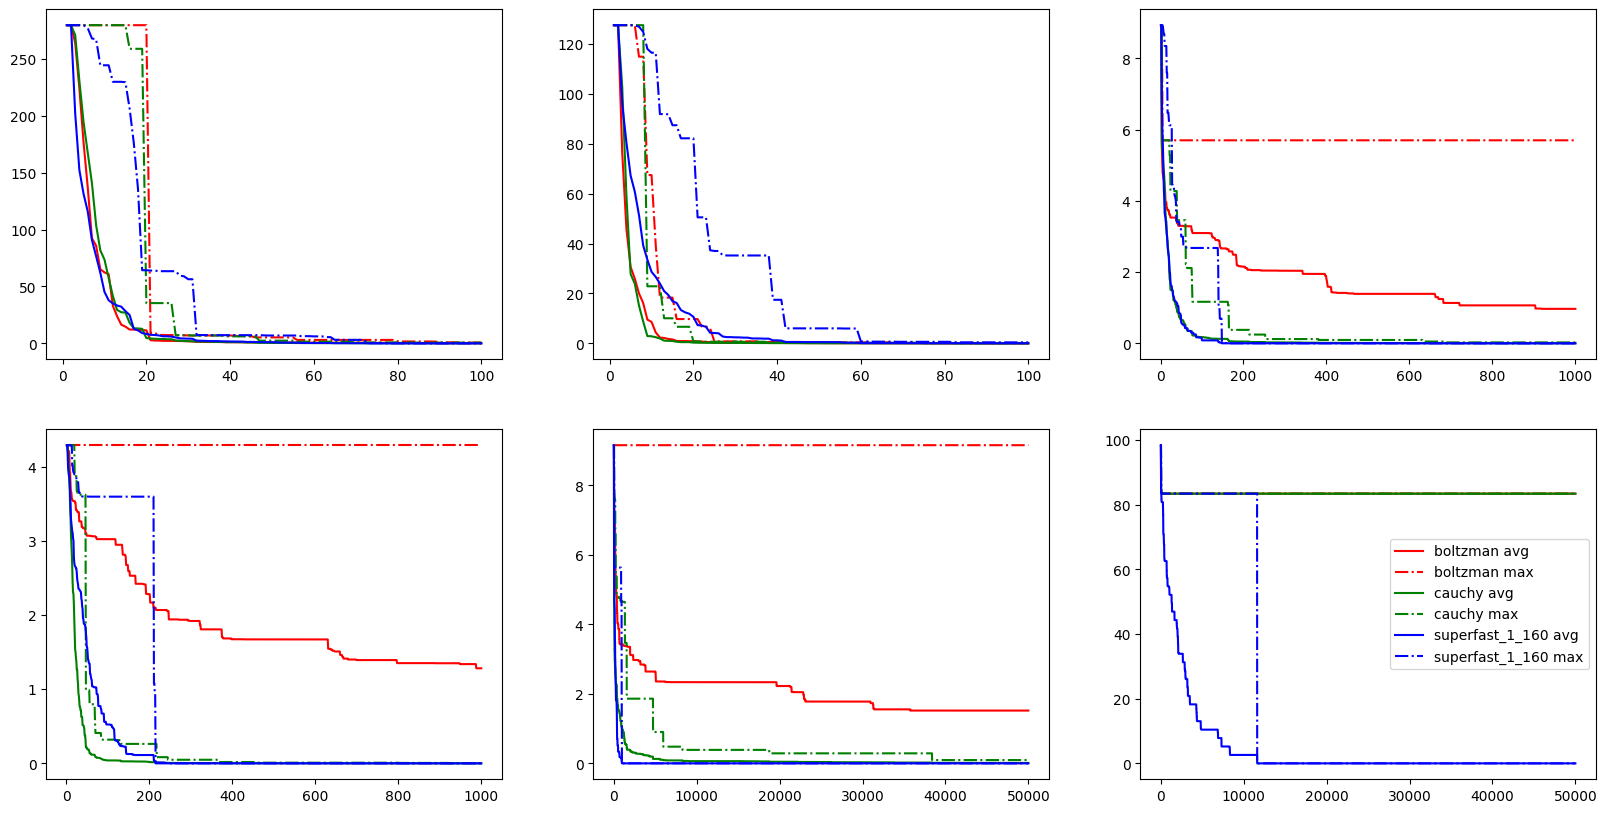

In [156]:
figure, axis = plt.subplots(2, 3)
figure.set_figwidth(20)
figure.set_figheight(10)

colors = {
    'boltzman': 'r', 
    'cauchy': 'g', 
    'superfast_1_160': 'b'
}

for method_name, method_results in results.items():
    seeds_count, func_count, _ = method_results.shape 
    for ind in range(func_count):
        k_count = test_cases[ind].k
        prepared_res = method_results[:, ind, :k_count]
        axis[ind // 3, ind % 3].plot(np.arange(1, k_count + 1), np.sum(prepared_res, axis=0) / seeds_count, color=colors[method_name], linestyle='-', label=f'{method_name} avg')
        axis[ind // 3, ind % 3].plot(np.arange(1, k_count + 1), np.max(prepared_res, axis=0), color=colors[method_name], linestyle='-.', label=f'{method_name} max')

plt.legend();